# Bayesian A/B testing

구글 옵티마이즈의 A/B 테스팅 모델을 이용할 수 없는 경우(예를 들어 실험 중간에 오타가 발견되어 실험을 중지하고 거의 같은 실험을 다시 라이브 했는데 두 실험 결과를 통합해서 보고 싶은 때) 간단한 베이지안 모델을 통해 확률을 계산해서 보여주기 위해 만들어진 페이지입니다. 

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm
import numpy as np

In [2]:
sessionA = 1917+1073
sessionB = 1984+1112
sessionC = 2560+1420
crA = 136+82 
crB = 154+77
crC = 179+127

In [3]:
# A안
A = np.hstack(([0]*(sessionA-crA),[1]*crA))
# B안
B = np.hstack(([0]*(sessionB-crB),[1]*crB))
# C안
C = np.hstack(([0]*(sessionC-crC),[1]*crC))

In [4]:
# Create a uniform prior for the probabilities p_a, p_b, and p_c

with pm.Model() as model:
    pA = pm.Uniform("pA", 0, 1)
    pB = pm.Uniform("pB", 0, 1)
    pC = pm.Uniform("pC", 0, 1)
 
    # Creates a posterior distribution of A - B
    deltaAB = pm.Deterministic("deltaAB", pA - pB)
    
    # Creates a posterior distribution of A - C
    deltaAC = pm.Deterministic("deltaAC", pA - pC)

    # Create the Bernoulli variables for the observation
    obsA = pm.Bernoulli('obsA', pA, observed = A)
    obsB = pm.Bernoulli('obsB', pB, observed = B)
    obsC = pm.Bernoulli('obsC', pC, observed = C)
 
    # Sample 21000 points and throw out the first 1000
    step = pm.Metropolis()
    trace = pm.sample(21000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [pC]
>Metropolis: [pB]
>Metropolis: [pA]
Sampling 2 chains: 100%|██████████| 43000/43000 [00:35<00:00, 1226.62draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [5]:
pA_samples = burned_trace["pA"]
pB_samples = burned_trace["pB"]
pC_samples = burned_trace["pC"]
deltaAB_samples = burned_trace["deltaAB"]
deltaAC_samples = burned_trace["deltaAC"]

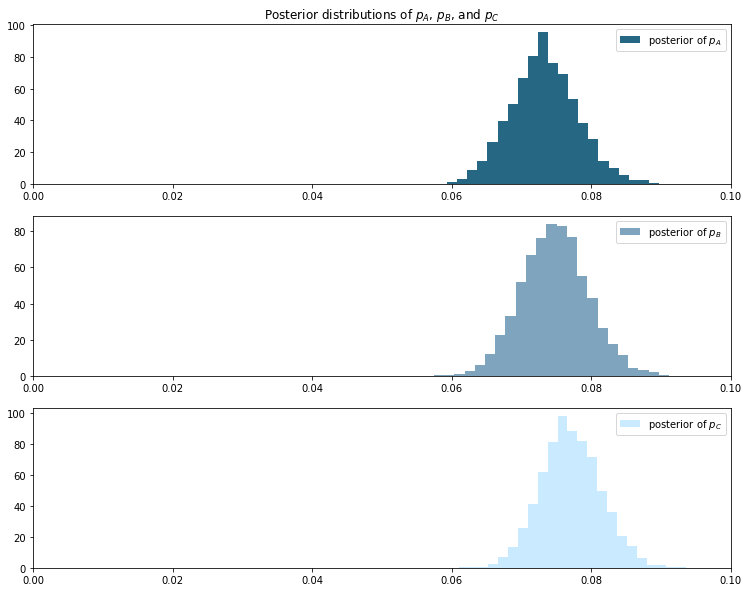

In [6]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(pA_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#004c6d", density=True)
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and $p_C$")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(pB_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#6996b3", density=True)
plt.legend(loc="upper right")

ax = plt.subplot(313)

plt.xlim(0, .1)
plt.hist(pC_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_C$", color="#c1e7ff", density=True)
plt.legend(loc="upper right")

In [7]:
print("B안이 원본보다 실적이 높을 확률: {}%".format(
    round(np.mean(deltaAB_samples < 0)*100, 2)))

print("C안이 원본보다 실적이 높을 확률: {}%".format(
    round(np.mean(deltaAC_samples < 0)*100, 2)))

B안이 원본보다 실적이 높을 확률: 58.99%
C안이 원본보다 실적이 높을 확률: 72.54%
